# Dilution Series and Effects of Data Aggregation

## Phil Wilmarth, OHSU PSR Core

### February 2018 and updated January 2019

---
# Overview
In this notebook, the effect of aggregation in isobaric labeling proteomics data will be explored. The aggregation method will be summing of reporter ion peak heights (intensity values). Data characteristics of peptide-spectrum-matches (PSMs), which have no aggregation, will be compared to peptides (limited aggregation) and to proteins (more aggregation).

#### This notebook will demonstrate that aggregation improves data quality in isobaric labeling

### Notebook Organization
1. [Compare data scatter](#section1)
1. [edgeR normalization](#section2)
1. [Compare CV distributions](#section3)

---

<a id='section1'></a>

## 1. Compare PSM, peptide, and protein data scatter
This is a complex mouse brain mixture, digested, split into 6 aliquots, labeled with 6 TMT reagents, and mixed in a series of dilutions. The relative volume amounts were in these proportions:  25 : 20 : 15 : 10 : 5 : 2.5. The biological sample was from the [Gail Mandel lab](https://www.ohsu.edu/xd/research/centers-institutes/vollum/faculty/mandel-lab/) at OHSU.

The data were generated on a Thermo Fusion using the SPS MS3 method (McAlister 2014). The peptide identifications and reporter ion intensities were generated using an in-house pipeline with Comet (Eng 2013) as the search engine. The [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git) (Wilmarth 2009) does a direct processing of the RAW files to extract MS2 scans for Comet and the reporter ions from the corresponding MS3 scans (Chambers 2012). Comet results are filtered using a target/decoy strategy with accurate mass conditional score histograms. Basic parsimony logic is used to generate protein and peptide reports.

An additional [protein grouping algorithm](https://digitalcommons.ohsu.edu/etd/3855/) is also employed to group protein families having large fractions of identical common peptides. The final list of proteins is used as the context for shared and unique peptide determinations. Only unique peptides in that context are used in the TMT quantification. All unique PSM reporter ions are summed into protein intensity totals for each channel. We will compare some properties of the reporter ions at the PSM level, the peptide level (combined copies and charge states), and the protein level. This analysis is similar to what was shown in Figure 3 of Wenger et al., 2011.

### References

> Chambers, M.C., Maclean, B., Burke, R., Amodei, D., Ruderman, D.L., Neumann, S., Gatto, L., Fischer, B., Pratt, B., Egertson, J. and Hoff, K., 2012. A cross-platform toolkit for mass spectrometry and proteomics. Nature biotechnology, 30(10), p.918. [link](https://www.nature.com/articles/nbt.2377)

>Eng, J.K., Jahan, T.A. and Hoopmann, M.R., 2013. Comet: an open‐source MS/MS sequence database search tool. Proteomics, 13(1), pp.22-24. [link](https://onlinelibrary.wiley.com/doi/abs/10.1002/pmic.201200439)

> McAlister, G.C., Nusinow, D.P., Jedrychowski, M.P., Wühr, M., Huttlin, E.L., Erickson, B.K., Rad, R., Haas, W. and Gygi, S.P., 2014. MultiNotch MS3 enables accurate, sensitive, and multiplexed detection of differential expression across cancer cell line proteomes. Analytical chemistry, 86(14), pp.7150-7158. [link](https://pubs.acs.org/doi/abs/10.1021/ac502040v)

> Wenger, C.D., Phanstiel, D.H., Lee, M.V., Bailey, D.J. and Coon, J.J., 2011. COMPASS: A suite of pre‐and post‐search proteomics software tools for OMSSA. Proteomics, 11(6), pp.1064-1074. [link](https://onlinelibrary.wiley.com/doi/full/10.1002/pmic.201000616)

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234. [link](https://link.springer.com/article/10.1007/s12177-009-9042-6)

### Workflow
- load R libraries
- load the three data files
- filter out rows with any zero intensities
- plot intensity distributions
- make scatter plots
- make [MA plots](https://en.wikipedia.org/wiki/MA_plot)

In [1]:
# load the R libraries
library(tidyverse)
library(stringr)
library(edgeR) # used in Parts 2 and 3

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘edgeR’ was built under R version 3.5.1”Loading required package: limma
Warning message:
“package ‘limma’ was built under R version 3.5.1”

The PSM data comes from the reporter ion table for each MS3 scan extracted directly from the converted RAW file. This is unfiltered data. This is **not** a list of PSMs associated with the identified peptides and proteins.

The peptide and protein CSV files are extracted from the normal PAW report files for proteins and peptides. For this analysis, we do not need to know the identities of any of the proteins or peptides. Only the columns of the reporter ion intensities (for all 10 reporter ion channels) were extracted for the CSV files.

This was a 6-plex labeling kit so there were only 6 of the 10 (or 11) channels that actually have labeled peptides. We will drop the unused 4 channels after reading the CSV files and set some more descriptive column names based on the dilution factors.

In [2]:
# Set up to select the proper columns and label them
keep <- c(1, 2, 5, 6, 9, 10)
labels = c("a_25", "b_20", "c_15", "d_10", "e_5", "f_2.5")

# read in the PSM dataset, keep the 6 columns, and set labels
psm_start <- read_csv("psm_tmt.csv")
psm_start <- psm_start[keep]
colnames(psm_start) <- labels

# PAW Grouped peptides
peptide_start <- read_csv("grouped_peptide_summary_TMT_8.csv")
peptide_start <- peptide_start[keep]
colnames(peptide_start) <- labels

# PAW grouped proteins
protein_start <- read_csv("grouped_protein_summary_TMT_8.csv")
protein_start <- protein_start[keep]
colnames(protein_start) <- labels

Parsed with column specification:
cols(
  height_126 = col_double(),
  height_127_N = col_double(),
  height_127_C = col_double(),
  height_128_N = col_double(),
  height_128_C = col_double(),
  height_129_N = col_double(),
  height_129_C = col_double(),
  height_130_N = col_double(),
  height_130_C = col_double(),
  height_131 = col_double()
)
Parsed with column specification:
cols(
  TotInt_126C_MAN1353 = col_double(),
  TotInt_127N_MAN1353 = col_double(),
  TotInt_127C_MAN1353 = col_double(),
  TotInt_128N_MAN1353 = col_double(),
  TotInt_128C_MAN1353 = col_double(),
  TotInt_129N_MAN1353 = col_double(),
  TotInt_129C_MAN1353 = col_double(),
  TotInt_130N_MAN1353 = col_double(),
  TotInt_130C_MAN1353 = col_double(),
  TotInt_131N_MAN1353 = col_double()
)
Parsed with column specification:
cols(
  TotInt_126C_MAN1353 = col_double(),
  TotInt_127N_MAN1353 = col_double(),
  TotInt_127C_MAN1353 = col_double(),
  TotInt_128N_MAN1353 = col_double(),
  TotInt_128C_MAN1353 = col_double(),
  

We will do some heavy-handed data filtering for this analysis. We will remove any rows in the data frames that have any zero values. We will be doing log transformations of intensities for some plots so we have to do something with zero values, or we will get mathematical errors. The choices are to drop rows with zeros or to do some sort of zero replacement. We will pick the easier (but more heavy-handed) option. 

> This is not quite true as the PAW pipeline normally does a zero replacement when only a few channels out of the set are zeros. The smallest non-zero peak height intensities are about 330 from this first-generation Fusion instrument in the SPS MS3 mode. A value of 50 was used as the replacement for zeros **only** for proteins. 

Depending on the type of data being imported, "missing" data may be denoted by an actual zero or a blank. The zeros get converted to 0.0; the blanks become NA (not available) or NAN (not a number). To drop rows with NA values, we would need a slightly different logical test. The topic of what to do with missing data in TMT experiments is not trivial and also depends on data aggregation. You can read more [here](https://pwilmart.github.io/blog/2018/12/12/TMT-zero-replacement).

See how many rows we have in the data frames before and after the filtering steps:

In [3]:
# filter out rows with any missing data points and see how many rows remain
psms <- psm_start[apply(psm_start, 1, function(x) all(x > 0)), ] 
print("PSMs (before and after filtering zeros):")
format(c(nrow(psm_start), nrow(psms)), digits = 0, big.mark = ',')
                        
peptides <- peptide_start[apply(peptide_start, 1, function(x) all(x > 0)), ] 
print("Peptides (before and after filtering zeros):")
format(c(nrow(peptide_start), nrow(peptides)), digits = 0, big.mark = ',')
                                
proteins <- protein_start[apply(protein_start, 1, function(x) all(x > 0)), ] 
print("Proteins (before and after filtering zeros):")
format(c(nrow(protein_start), nrow(proteins)), digits = 0, big.mark = ',')

[1] "PSMs (before and after filtering zeros):"


[1] "216,103" " 59,698"

[1] "Peptides (before and after filtering zeros):"


[1] "28,799" "20,632"

[1] "Proteins (before and after filtering zeros):"


[1] "2,781" "2,689"

We can also look at the 6 column sums to see that we actually have a proper dilution series.

> When we have repeated code patterns (we are doing the same thing to PSMs, peptides, and proteins), it might be worth the time to create a function that we can call multiple times. This can increase potential for code reuse and reduce the chance to make typing and/or logic errors. It is easier to debug/modify one function rather than multiple blocks of similar code. These print statements are in the 6 versus half a dozen category (it is a toss-up). If you are doing a lot of cutting and pasting in a notebook, it might be time to write a function.

In [4]:
# check column sums for PSMs, peptides, and proteins
print("PSMs column sums:")
format(round(colSums(psms), digits = 0), big.mark = ",")

print("Peptide column sums:")
format(round(colSums(peptides), digits = 0), big.mark = ",")

print("Protein column sums:")
format(round(colSums(proteins), digits = 0), big.mark = ",")

[1] "PSMs column sums:"


a_25            b_20            c_15            d_10             e_5 
"3,827,241,213" "3,088,914,690" "2,363,152,704" "1,665,392,787" "  778,998,204" 
          f_2.5 
"  434,946,648"

[1] "Peptide column sums:"


a_25            b_20            c_15            d_10             e_5 
"1,989,609,572" "1,555,232,467" "1,202,832,977" "  831,759,502" "  400,962,779" 
          f_2.5 
"  222,664,615"

[1] "Protein column sums:"


a_25            b_20            c_15            d_10             e_5 
"2,006,316,227" "1,570,213,930" "1,213,599,512" "  839,401,807" "  402,884,998" 
          f_2.5 
"  222,698,996"

### What do the intensity distributions for each channel look like?
Let's look at the distributions for the PSM-level data first. The x-axis is the log, base 2, of the intensities. Each dilution series is a separate, color-coded plot. Density distributions are kernel density estimates, which is a smoothed intensity histogram. ggplot needs tidy data in long format to make histograms or density plots, so we need to use the "gather" function.

#### Make plotting functions since we are doing everything 3 times

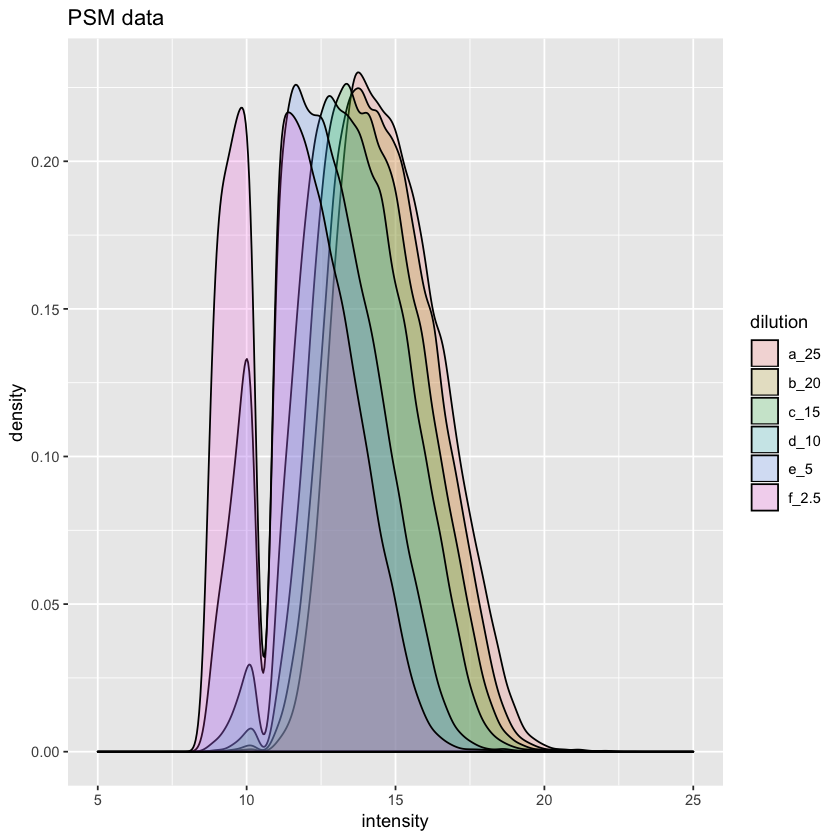

In [5]:
show_densities <- function(df, xmin, xmax, title) {
    # makes density distributions of the log2 intensities
        # df - data frame with TMT intensities
        # xmin, xmax - x axis limits
        # title- plot title
    
    # get data in long form
    df_long <- gather(log2(df), key = "dilution", value = "intensity")

    # make the density plots colored by dilution
    ggplot(df_long, aes(x = intensity, fill = dilution)) +
        geom_density(alpha = 0.2) + 
        ggtitle(title) +
        xlim(xmin, xmax)
}

# compare PSM intensity (peak heights) distributions
show_densities(psms, 5, 25, "PSM data")

### There is a pronounced lower-intensity "notch"
There is a low intensity drop out or "notch" at a log2 intensity of 11. It is more pronounced for the 5 and 2.5 dilution series where the reporter ion intensities are smaller. 

This "notch" has been reported previously:

> Hughes, C.S., Zhu, C., Spicer, V., Krokhin, O.V. and Morin, G.B., 2017. Evaluating the Characteristics of Reporter Ion Signal Acquired in the Orbitrap Analyzer for Isobaric Mass Tag Proteome Quantification Experiments. Journal of proteome research, 16(5), pp.1831-1838.

### Let's look at the more aggregated peptide-level data

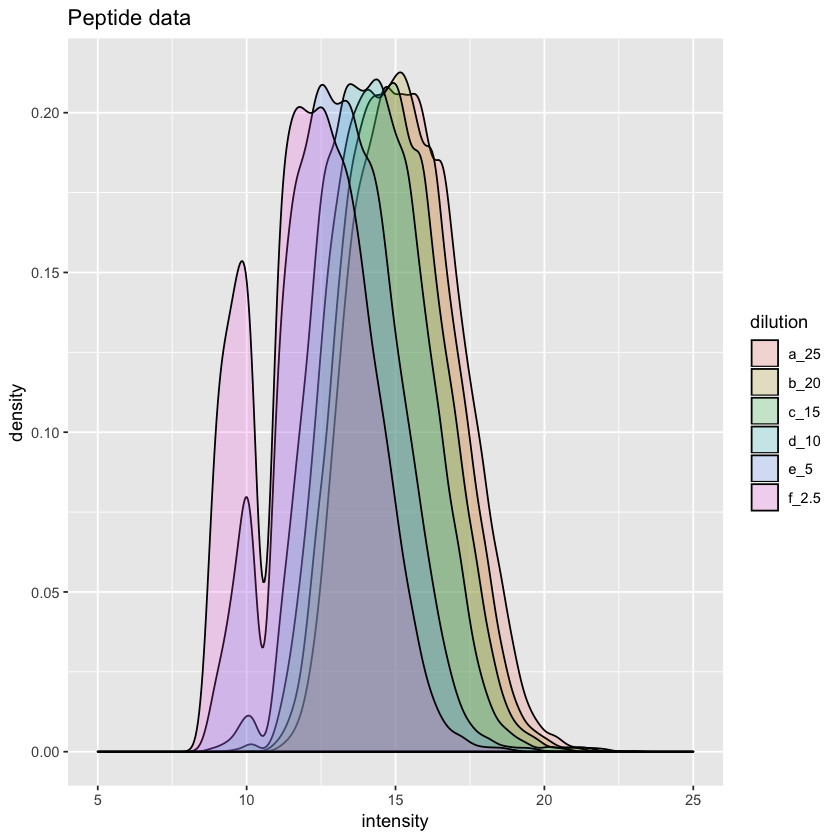

In [6]:
# compare peptide intensity (peak heights) distributions
show_densities(peptides, 5, 25, "Peptide data")

### The notch is still present, but reduced
The summation of multiple PSMs (in most cases) into peptides increases the magnitude of the intensities a little and seems to reduces the relative effect of the notch.

### Finally, look at protein-level intensity distributions

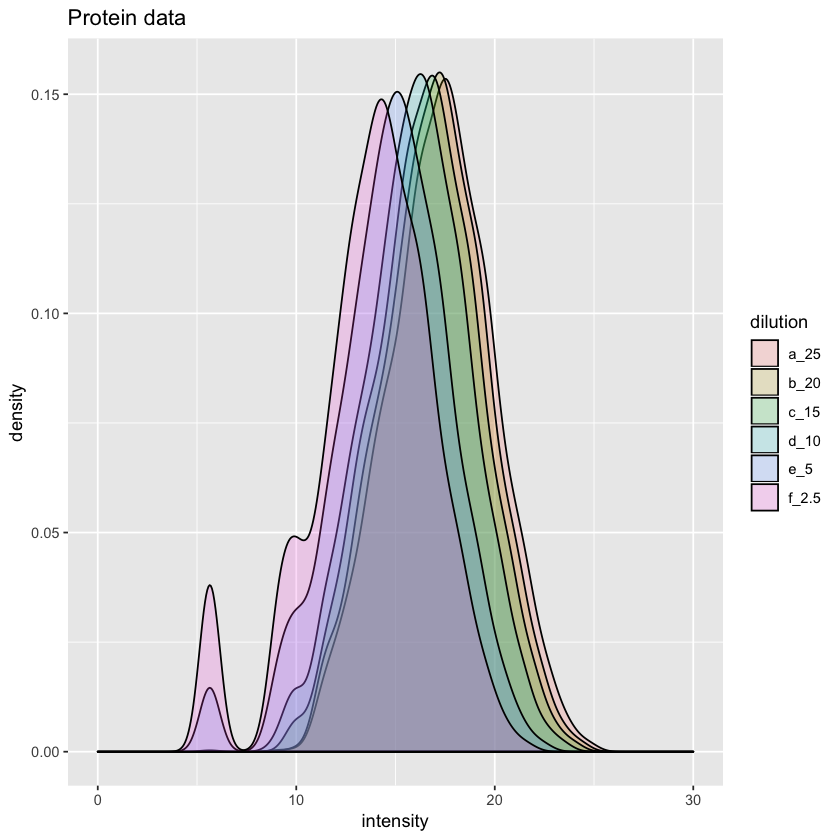

In [7]:
# compare protein intensity (peak heights) distributions
show_densities(proteins, 0, 30, "Protein data")

### The notch is mostly gone at the protein level
We required at least two peptides per protein, so most protein intensities are aggregated from several PSMs. This seems to average out the notch (the small bumps still at 11-ish) and the distributions look much better. The low peak in the proteins at log2 intensity of 5.6 is from the zero-replacement value of 50. We can see that the need for replacing missing data depends strongly on the amount of digest in the channel and is only occurring in the 2.5 and 5 dilution channels.

### Prepare the data for scatter plots
We will use the average of the 6 intensities as the x-axis and plot each dilution series (the different reporter ion channels) against that average vector. We will use different colors for each dilution series channel and overlay 6 scatter plots in one figure. We will show the scatter plots with **linear axis scales**, so we can better see the behavior of the underlying data. We will add a straight trend line for each series.

#### Make a function for the plotting because we will call it three times

In [8]:
# helper function for scatter plots
show_scatter <- function(df, title) {
    # makes linear scale scatter plots (all series against reference)
        # df - tidy data frame with intensities and average reference vector
        # title - plot title
    
    # add the reference column (average) and put into long form for ggplot
    df$ref <- rowMeans(df)
    gg_df <- gather(df, key = dilution, value = intensity, a_25:f_2.5)
    
    # make the full range scatter plot
    full  <- ggplot(data = gg_df, aes(x = ref, y = intensity)) +
        geom_point(aes(color = dilution, shape = dilution), alpha = 0.5) +
        geom_smooth(aes(color = dilution), method = "lm") +
        ggtitle(title)

    # expanded scale
    expanded <- ggplot(data = gg_df, aes(x = ref, y = intensity)) +
        geom_point(aes(color = dilution, shape = dilution), alpha = 0.5) + 
        geom_smooth(aes(color = dilution), method = "lm") +
        coord_cartesian(xlim = c(0, 500000), ylim = c(0, 500000)) +
        ggtitle(str_c(title, " (expanded scale)"))
    
    print(full) 
    print(expanded)
}

### Look at the PSMs first
We have not done any filtering for the PSMs other than removing zeros. They are the raw peak heights. There will be duplicates of the same peptides. There will also be signals from contaminants and decoys.

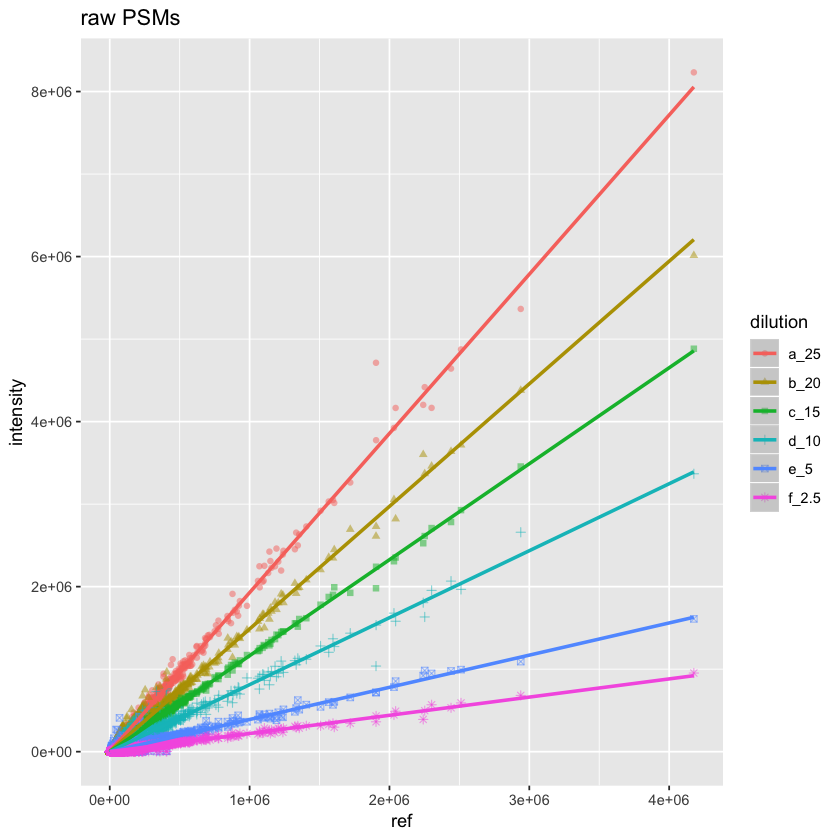

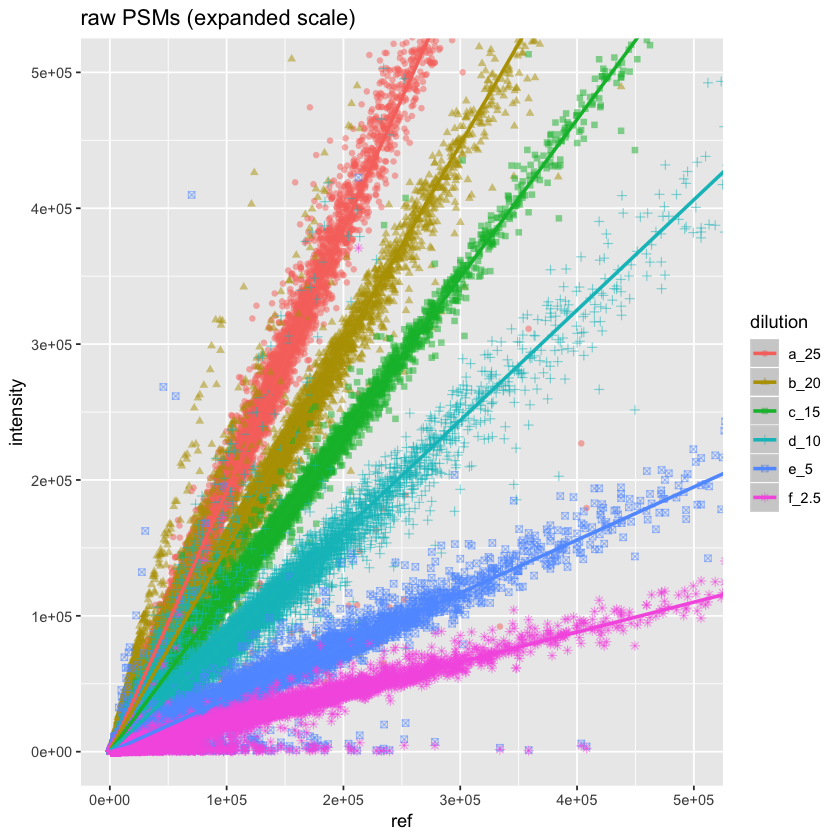

In [9]:
# scater plots for PSMs
show_scatter(psms, "raw PSMs")

### The PSM data from different dilutions are separate
The different dilution series are separating by intensities. The separation is better for more intense PSMs and the scatter in the data increases as the intensities gets smaller towards the origin. Overall, the data has a lot of variability.

### Peptides next
These have been filtered a bit more than the PSMs were. The peptides are aggregated from just the 1% FDR PSMs. Matches to contaminants and decoy have been removed. We have done parsimonious protein inference and an additional protein grouping step. Shared and unique peptide status were determined from the final list of reported proteins. Any shared peptides have been excluded (this was done in Excel before exporting the CSV file). These are only the peptides associated with the confidently identified and quantifiable proteins. 

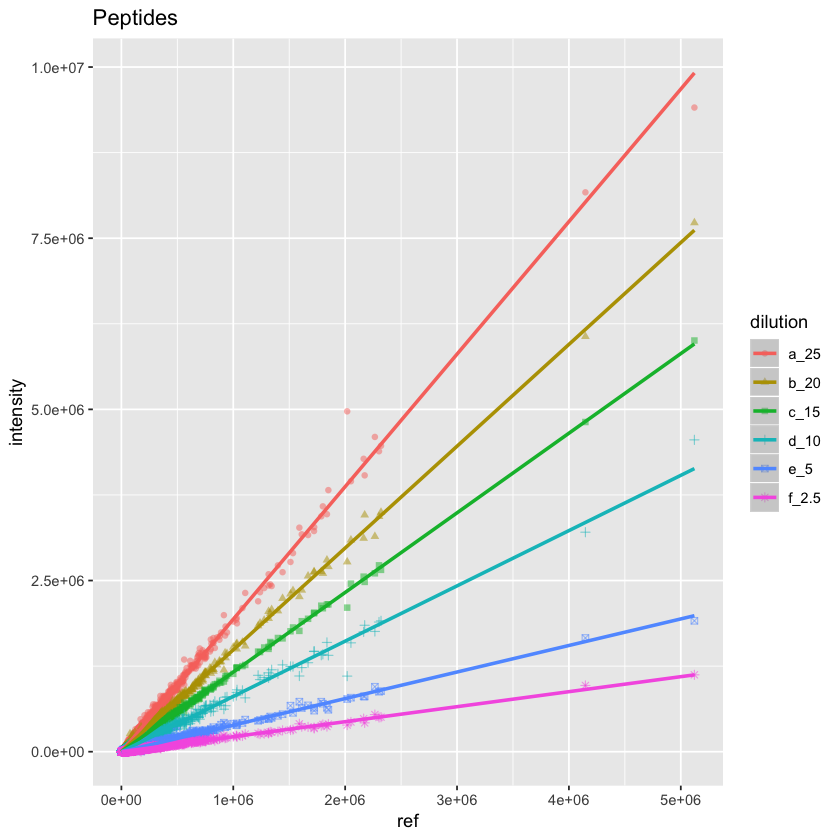

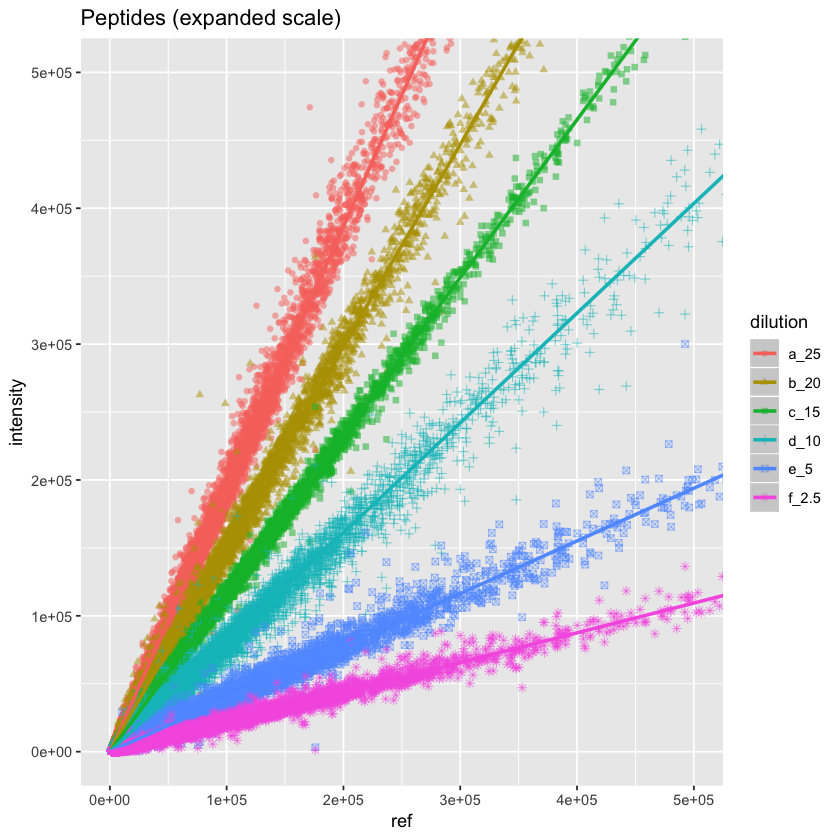

In [10]:
# scater plots for peptides
show_scatter(peptides, "Peptides")

### Peptides look much better than PSMs
Peptides look a lot better than raw PSMs. That may not be a completely fair conclusion, however. We might want to do more work and select just the PSMs associated with these peptides to see whether it was the filtering of the peptides or the aggregation of PSMs up to peptides that is making the peptide data look better than the PSM data.

From the numbers at the top of the notebook, there are 60K PSMs that reduce to 20K peptides. We have about a 3-fold reduction in number of data points. This is an intermediate degree of data aggregation.

### Finally, the proteins
Like the peptides, any contaminants and decoy proteins have been excluded. The protein totals only include unique peptides. Zero values were replaced by a value of 50. The PAW pipeline has a few places where replacement of zero intensities could happen. I have finally come to the conclusion that the best place to do that (if at all) is at the final protein intensity level. There is quite a lot (8-fold) of aggregation when going from peptides (20K) to proteins (2.7K).

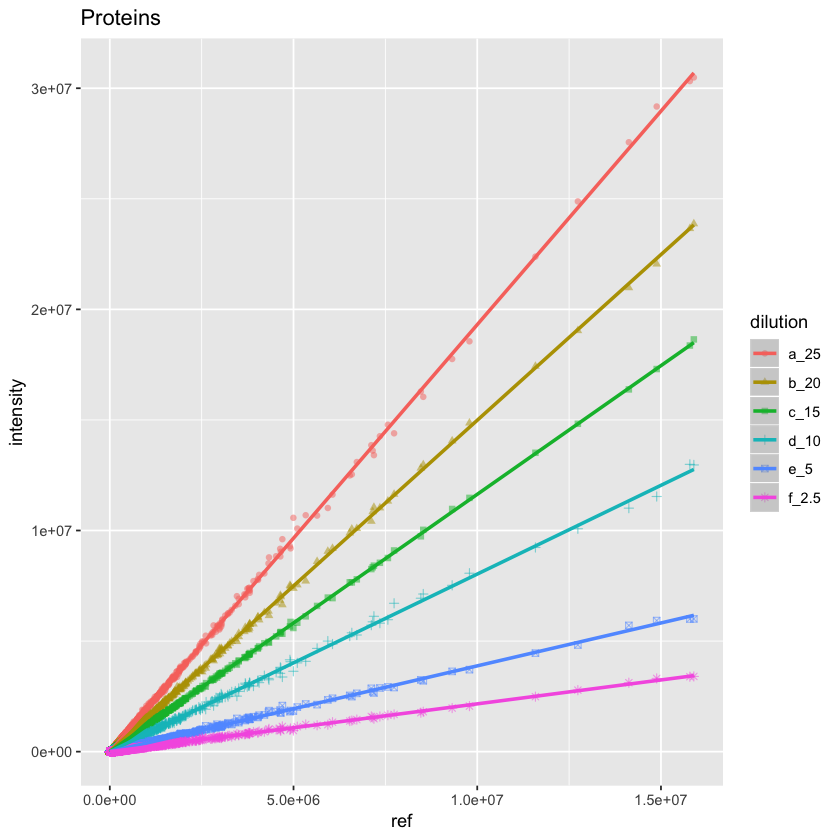

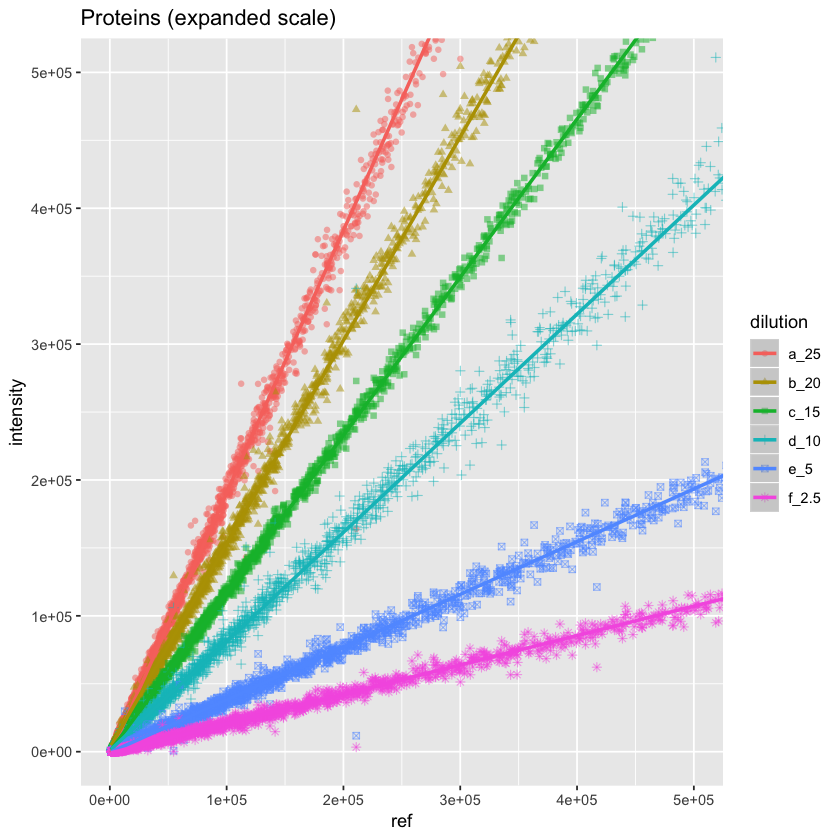

In [11]:
# scater plots for proteins
show_scatter(proteins, "Proteins")

### Proteins are much tighter to the trend lines
The aggregation of PSMs and peptides to total protein intensities has a pretty dramatic improvement on the consistency of the data (how close the proteins are to the trend lines) over the full dynamic range. We might expect some increased scatter at low protein intensities as the number of data values being combined into the protein totals goes down. We will do some calculations to see how much tighter the data become as a function of aggregations level below after we take a little detour into TMM normalization (part of the edgeR R package).

### MA plots are an alternative to scatter plots
We will also make data frames for [MA style plots](https://en.wikipedia.org/wiki/MA_plot). Those plots have transformed axes (log2 ratios on y-axis, and log10 average intensity on x-axis). We will do the average intensity in log10 scale (that is easier to mentally "unlog" to get back to intensities). We will do the ratios (M-values) in log2 scale since that is more commonly used for fold changes. 

### MA plots will stack vertically by ratio to reference
MA plots are fold change on the y-axis (typically log2 of expression ratios) and a log10 average intensity on the x-axis. We have the average intensity as the reference column. The log10 of that will be our x-axis values. The ratio of each dilution series to the reference will be the y-axis (as log2 of the ratio). Each dilution series should be a horizontal line located at the expected ratio. The dilution series will stack vertically with the more concentrated series (25) on top. 

#### We can do the transformations and plotting using a helper function

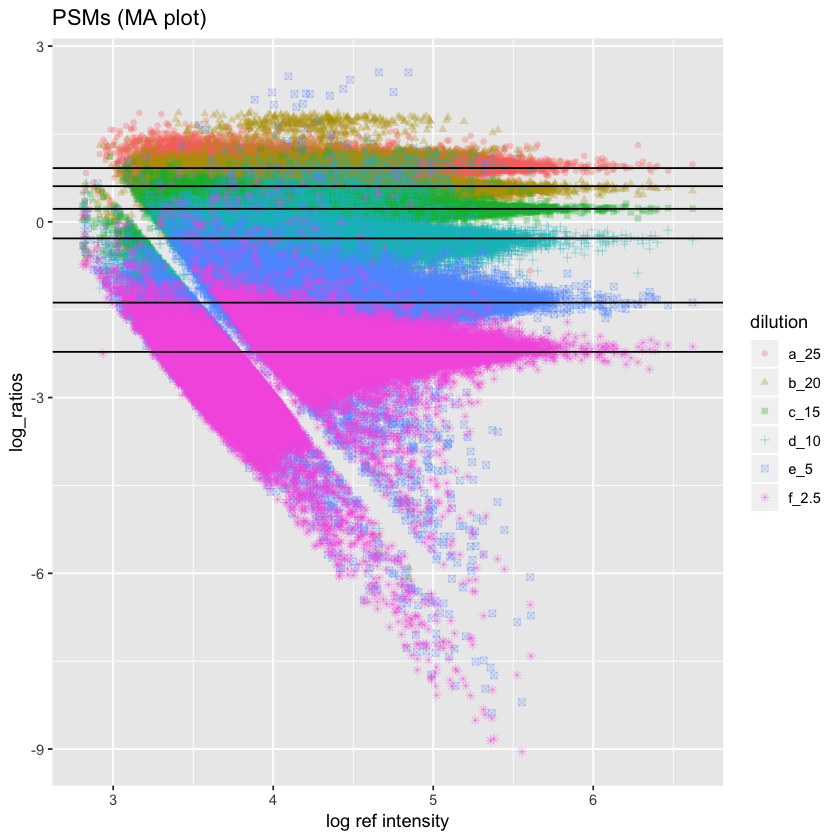

In [12]:
# MA style plot for PSMs
show_MA_plot <- function(df, title) {
    # transforms the data and makes MA plots (all versus reference)
        # df - data frame with intensities and reference vector
        # title - plot title
    
    # take ratios relative to reference then log transform
    df$ref <- rowMeans(df)
    log_df <- log2(df[1:6] / df$ref) # these are log 2
    log_df$ref <- log10(df$ref) # this stays in log 10
    
    # we need data in tidy long form
    gg_log_df <- gather(log_df, key = dilution, value = log_ratios, a_25:f_2.5)
    
    # compute the expected horizontal lines
    ratios <- log2(colMeans(df)[1:6] / colMeans(df)[7])
    
    # make the plot
    ggplot(data = gg_log_df, aes(x = ref, y = log_ratios)) +
        geom_point(aes(color = dilution, shape = dilution), alpha = 0.3) +
        geom_hline(yintercept = ratios) +
        xlab("log ref intensity") + 
        ggtitle(title)
}
    
# make some MA plots for PSMs
show_MA_plot(psms, "PSMs (MA plot)")

### The "notch" is back!
The "notch" was not apparent in the scatter plots. We see it here as a top-left to bottom-center swath of missing points. The natural scale of TMT data is the intensity values. Both axes in MA plots are transformations of the native data. The y-axis in MA plots is typically auto-scaled to the range of fold-changes. Data sets with large fold changes look similar to data sets with small fold changes. The scatter plots are more true to the data, and differences in the data characteristics tend to produce scatter plots that look different. 

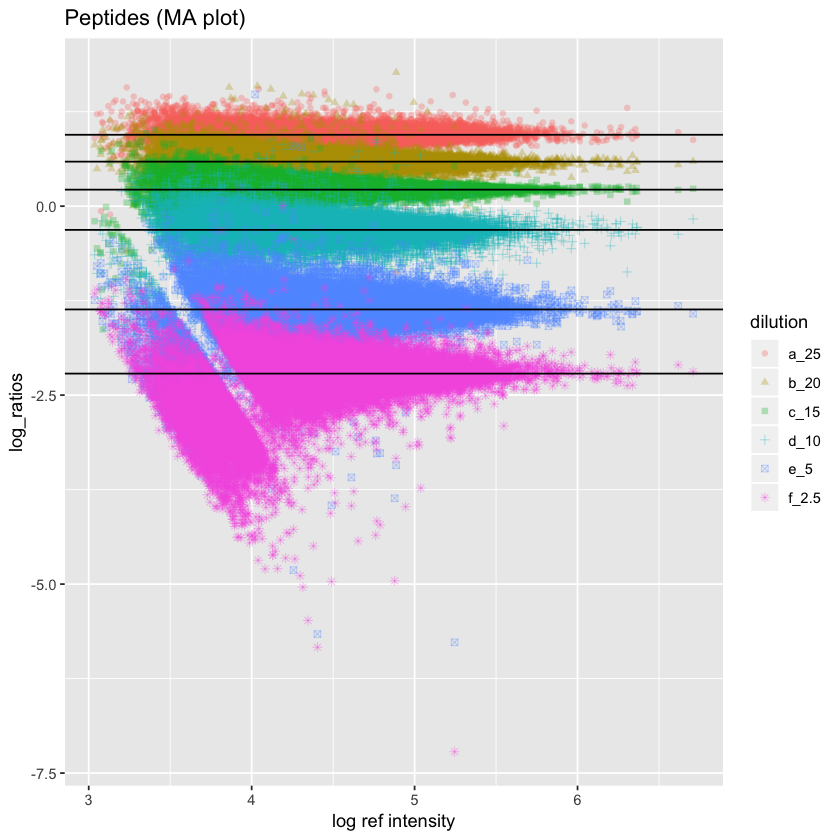

In [13]:
# make some MA plots for peptides
show_MA_plot(peptides, "Peptides (MA plot)")

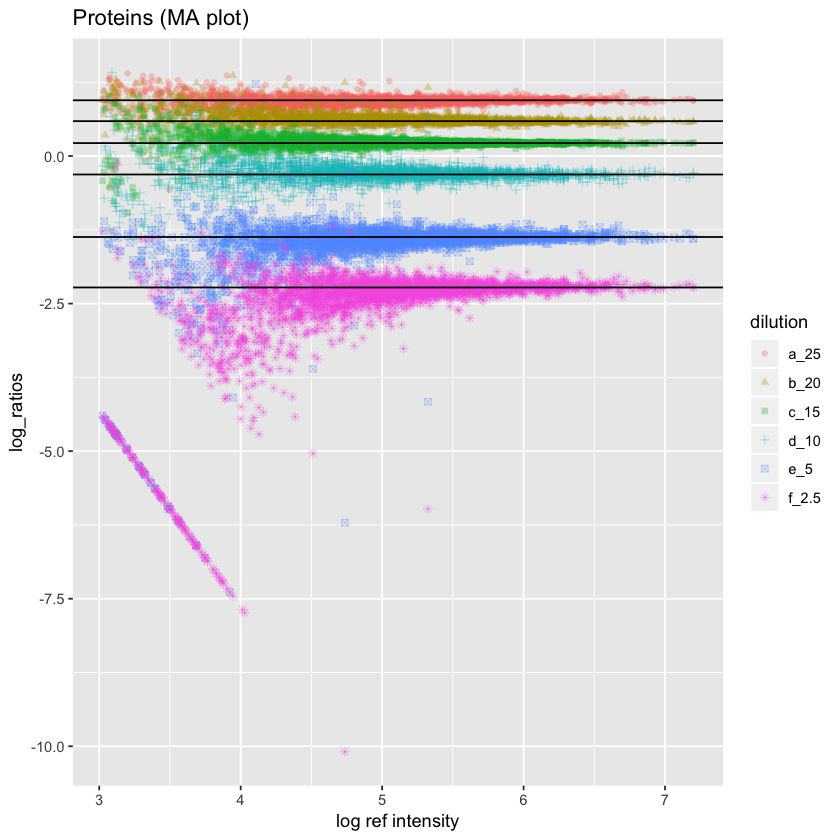

In [14]:
# make some MA plots for proteins
show_MA_plot(proteins, "Proteins (MA plot)")

### Aggregation to proteins results in the best data
Peptides look better behaved than PSMs, but we still have a lot of overlap between data from the different dilution series. Granted, the differences between many of the dilution values are rather small. The protein data is much reduced in scatter about the expected ratio solid black lines and the different dilution series are pretty well resolved from each other. The lower left diagonal line of data points in the proteins plot comes from the zero replacement values that are mostly associated lower intensities and with the 2.5 and 5 series. Note that the fold changes between the upper series (25, 20, and 15) are all small.

The log scales and vertical separation by relative expression level let us see what is going on at lower abundances more clearly than the fan-like scatter plots. Weak reporter ion signals have more asymmetry in their scatter about the horizontal lines (biased towards points below the expected horizontal lines). We see this mostly for the 5 and 2.5 series data. Less diluted samples (25, 20) also have increasing variance at low intensities, but do not seem to have as much asymmetry in the scatter. 

---

## Background for Parts 2 and 3

There are two factors that are important in measurements: accuracy and reproducibility. Accuracy for this data is not that interesting. The measured dilution factors and the known dilution factors are in good agreement (see next cell). The trend lines in the scatter plots and the black, horizontal lines in the MA plots show that the data separate in intensity by the expected dilutions. There is quite a lot of published evidence that the SPS MS3 method improves the dynamic range and accuracy of isobaric labeling. As might be expected, there is a clear trend that lower intensity data has more uncertainty than higher intensity data. 

In [15]:
# how close were the measured dilution factors?
tot_int <- sum(colSums(proteins))
unit <- tot_int / sum(c(25, 20, 15, 10, 5, 2.5))
round(colSums(proteins) / unit, 2)

a_25  b_20  c_15  d_10   e_5 f_2.5 
24.86 19.45 15.04 10.40  4.99  2.76

Reproducibility means that if we measured the same thing multiple times we would get a set of values that are close to each other. We have 6 measurements of the same sample here, but the same amount of the sample was not measured each time. However, we know the dilution factors so we can basically undo the dilutions with some data normalizations. Then we can get 6 repeated measures and check the data reproducibility. A common metric for reproducibility is the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) (CV), so we can compute the CV for each data frame row (either individual PSMs, peptides, or proteins) after normalizing the data to remove the dilution factors. Since we will have thousands of CV values, we will look at the distributions of the CV values. We have seen that aggregation seems to reduce data dispersion (scatter). We can compute median CV values and interquartile ranges for PSMs, peptides, and proteins.

<a id='section2'></a>

## 2. Understanding data normalizations in edgeR 

We have many options for normalizing the data. We can use the known dilution factors to "undo" the pipetting differences. We could also measure the grand intensity totals for each channel and use single, global scaling factors to match the totals. The Bioconductor package [edge](https://bioconductor.org/packages/release/bioc/html/edgeR.html) seems to work well for statistical testing in TMT experiments and it incorporates a nice trimmed mean of M-values normalization algorithm developed for these types of omic datasets. 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

While normalization in edgeR involves a single function call, understanding exactly what is done to the data is surprisingly hard. edgeR does not create tables normalized data and then do the statistics on the normalized data. The modeling in edgeR uses the normalization factors as terms in the statistical model, so they kind of stay hidden.

One confusing thing about normalization in edgeR is that there are really **two** sequential normalization steps rather than just one. After loading data into a DGEList object in edgeR, you can examine the object. This is a "list" object in R, a heterogeneous data container. The table of data values (counts for RNA-Seq or intensities for TMT) is a data frame ("counts" slot) in the list. Another data frame is the "sample" information. This has sample names, group memberships (e.g. control or treatment), library sizes, and (potentially) TMM normalization factors. If you are not familiar with edgeR, the [User's Guide](https://bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf) is well written. It does assume some familiarity with R and with statistical modeling - some additional readings may be needed.

#### Analysis steps
- load data into edgeR data structures
- see what library factors are and how they are used
- compare edgeR cpm function to doing things by hand
- run TMM normalization and understand the factors
- see how to use the TMM factors to get normalized data

In [16]:
# loading the edgeR library was done at the top of the notebook
# load data into DGEList objects (counts are intensities, group are sample labels)
# the original data frames have added columns so we need just the first 6 cols

# PSMs first
y_psms  <- DGEList(counts = psms[1:6], group = factor(labels))
y_psms$samples

group lib.size   norm.factors
a_25  a_25  3827241213 1           
b_20  b_20  3088914690 1           
c_15  c_15  2363152704 1           
d_10  d_10  1665392787 1           
e_5   e_5    778998204 1           
f_2.5 f_2.5  434946648 1

In [17]:
# peptides next
y_peptides  <- DGEList(counts = peptides[1:6], group = factor(labels))
y_peptides$samples

group lib.size   norm.factors
a_25  a_25  1989609572 1           
b_20  b_20  1555232467 1           
c_15  c_15  1202832977 1           
d_10  d_10   831759502 1           
e_5   e_5    400962779 1           
f_2.5 f_2.5  222664615 1

In [18]:
# finally, proteins
y_proteins  <- DGEList(counts = proteins[1:6], group = factor(labels))
y_proteins$samples

group lib.size   norm.factors
a_25  a_25  2006316227 1           
b_20  b_20  1570213930 1           
c_15  c_15  1213599512 1           
d_10  d_10   839401807 1           
e_5   e_5    402884998 1           
f_2.5 f_2.5  222698996 1

### lib.size column is important 
The norm.factors column is 1.0 in all cases. Does this mean that there will be will not be any data normalization? No, data is adjusted by library size in edgeR. What does that mean? It means that each column is going to be divided by the library size (the column sum) so that the scaled intensites will sum up to 1.0 for each sample. This puts all of the data on the same relative scale, but fractional numbers are not very easy to understand. edgeR has a "cpm" function that puts the data on a counts-per-million scale so that the numbers are easier to interpret. 

### Let's do what edgeR is doing by hand
For fun, let's do some manipulations of the protein data (in the cell above). We will verify that the column sums are the library size numbers.

In [19]:
# these are the original column sums (they should match the library sizes)
round(colSums(proteins[1:6]), 0)

a_25       b_20       c_15       d_10        e_5      f_2.5 
2006316227 1570213930 1213599512  839401807  402884998  222698996

The column sums and library factors are the same. If we divide by the column sums (the library factors), then each channel will sum up to 1.0.

In [20]:
# dividing by library sizes makes each sample sum to 1.0
scaled_proteins <- sweep(proteins[1:6], 2, y_proteins$samples$lib.size, FUN = "/")
round(head(scaled_proteins), 8)
colSums(scaled_proteins)

a_25       b_20       c_15       d_10       e_5        f_2.5     
1 0.00009386 0.00008686 0.00009019 0.00009245 0.00009343 0.00007329
2 0.00005322 0.00004698 0.00004522 0.00004379 0.00005241 0.00003875
3 0.00000651 0.00000681 0.00000625 0.00000754 0.00000593 0.00000539
4 0.00008003 0.00008349 0.00008833 0.00008346 0.00007873 0.00007570
5 0.00052053 0.00050138 0.00051121 0.00048847 0.00053511 0.00051547
6 0.00126270 0.00121809 0.00124991 0.00117849 0.00133927 0.00132685

a_25  b_20  c_15  d_10   e_5 f_2.5 
    1     1     1     1     1     1

Let's make them sum up to 1 million, i.e. let's make a cpm scale.

In [21]:
# make our own cpm scale
cpm_proteins <- scaled_proteins * 1000000
round(head(cpm_proteins), 0)
colSums(cpm_proteins)

a_25 b_20 c_15 d_10 e_5  f_2.5
1   94   87   90   92   93   73 
2   53   47   45   44   52   39 
3    7    7    6    8    6    5 
4   80   83   88   83   79   76 
5  521  501  511  488  535  515 
6 1263 1218 1250 1178 1339 1327

a_25  b_20  c_15  d_10   e_5 f_2.5 
1e+06 1e+06 1e+06 1e+06 1e+06 1e+06

The numbers on a cpm scale are easier to compare to each other than as fractional numbers. Compare the above to the cpm function in edgeR:

In [22]:
# use the cpm function in edgeR
round(head(cpm(y_proteins)), 0)
colSums(cpm(y_proteins))

a_25 b_20 c_15 d_10 e_5  f_2.5
1   94   87   90   92   93   73 
2   53   47   45   44   52   39 
3    7    7    6    8    6    5 
4   80   83   88   83   79   76 
5  521  501  511  488  535  515 
6 1263 1218 1250 1178 1339 1327

a_25  b_20  c_15  d_10   e_5 f_2.5 
1e+06 1e+06 1e+06 1e+06 1e+06 1e+06

### Library sizes are kind of a default normalization in edgeR
Even though the "norm.factors" are 1.0, edgeR is still going to do the library size scaling even if the calcNormFactors function is **not** called. The calcNormFactors runs the TMM normalization on top of the library size scaling. I suspect that the TMM algorithm works better on "partially" normalized data. 

### What is TMM normalization?
TMM stands for the trimmed mean of M-values. The trimming in TMM is sort of a two-dimensional trimming. Some of the highest abundance and some of the lowest abundance values are removed. We are looking for large fold-changes (in both directions) so TMM assumes that the large and small M-values (the log ratios) should also be trimmed. That kind of leaves all of the stuff in the "middle", which is assumed to be at the same expression levels between samples. TMM computes global scaling factors (single factors) that makes the middle stuff as similar as possible.

The TMM algorithm is very sensible when study designs match its assumptions. Most experiments I read about and have analyzed tend to be compatible with TMM assumptions. There are always exceptions, and it is **really important** to understand the conceptual "bigger picture" of any normalization algorithm. Only appropriate normalization methods that apply to a given experimental design should ever be used. This is **NOT** a try all and pick the best one exercise!  

We can run the trimmed mean of M-values algorithm and look at the "normalization" factors. Then we can re-run the "cpm" function after the TMM step and see if the result is the same as above.

In [23]:
# compute TMM factors - they get added to $samples
y_proteins_tmm <- calcNormFactors(y_proteins)
# round(y_proteins_tmm$samples$norm.factors, 6)
y_proteins_tmm$samples

group lib.size   norm.factors
a_25  a_25  2006316227 0.9993758   
b_20  b_20  1570213930 1.0194088   
c_15  c_15  1213599512 1.0146227   
d_10  d_10   839401807 1.0175049   
e_5   e_5    402884998 0.9825746   
f_2.5 f_2.5  222698996 0.9676453

In [24]:
# see what column sums we get after a cpm function call now that there are TMM factors
round(colSums(cpm(y_proteins_tmm)), 0)
round(mean(colSums(cpm(y_proteins_tmm))))

a_25    b_20    c_15    d_10     e_5   f_2.5 
1000625  980961  985588  982796 1017734 1033437

[1] 1000190

### norm.factors are not what we might have guessed
The libraries are very different in size (due to the sample dilutions), yet the "norm.factors" are all close to 1.0. This is because the TMM factors are in **addition** to the library size scaling. The way the "norm.factors" work is to adjust the effective library sizes. If the "lib.size" values are multiplied by the "norm.factors", then the column divided by the effective library size, you get the TMM normalized result.

If we call the "cpm" function after we have done the TMM normalization, we no longer get one million for each column total. Some column totals are a bit more and some are a bit less than 1 million. The average grand total is still basically 1 million (within rounding errors), so the up and down corrections are pretty balanced.

We can compute the normalization factors by hand (below) and make our own cpm data frame. We should get the same column totals as above.   

In [25]:
# adjust the library sizes by the TMM factors to get the real library size factors
real_factors <- y_proteins_tmm$samples$lib.size * y_proteins_tmm$samples$norm.factors

# apply the factors to get the TMM normalized data table (fractional scale)
proteins_tmm_norm <- sweep(proteins[1:6], 2, real_factors, FUN = "/")

# put TMM normalized data on a one million scale
by_hand_cpm <- proteins_tmm_norm * 1000000

round(head(by_hand_cpm), 0)
round(colSums(by_hand_cpm), 0)
round(mean(colSums(by_hand_cpm)))

a_25 b_20 c_15 d_10 e_5  f_2.5
1   94   85   89   91   95   76 
2   53   46   45   43   53   40 
3    7    7    6    7    6    6 
4   80   82   87   82   80   78 
5  521  492  504  480  545  533 
6 1263 1195 1232 1158 1363 1371

a_25    b_20    c_15    d_10     e_5   f_2.5 
1000625  980961  985588  982796 1017734 1033437

[1] 1000190

### edgeR does two normalization steps and keeps the factors separate
We see that edgeR always does a library size normalization step. The **optional** trimmed mean of M values normalization is in addition to the library size normalization, and the TMM factors are library size adjustment factors. The TMM factors scale the library sizes, which are in the denominators, so you have to divide, not multiple, by the TMM factors.

---
<a id='section3'></a>

## 3. Variance differences between PSM, peptide, and protein intensities

### Put the data on a common scale and compute CVs for PSMs, peptides, and proteins
What was the point to Section 2? We saw that the library size corrections in edgeR basically "undo" the dilutions. We can do even a little bit more tweaking to get the six channels as similar as possible by adding TMM normalizations. edgeR has a cpm function that returns a data frame with the data points normalized and with data values that are on a nice scale. 

If we take the data that was loaded into edgeR above, we can normalize the channels, and make cpm data frames. That will put all 6 channels on a similar scale, and then we can compute the coefficients of variance (CVs). We will print out the distribution summaries and compare boxplots.

### Check how well the normalizations "undo" the dilutions

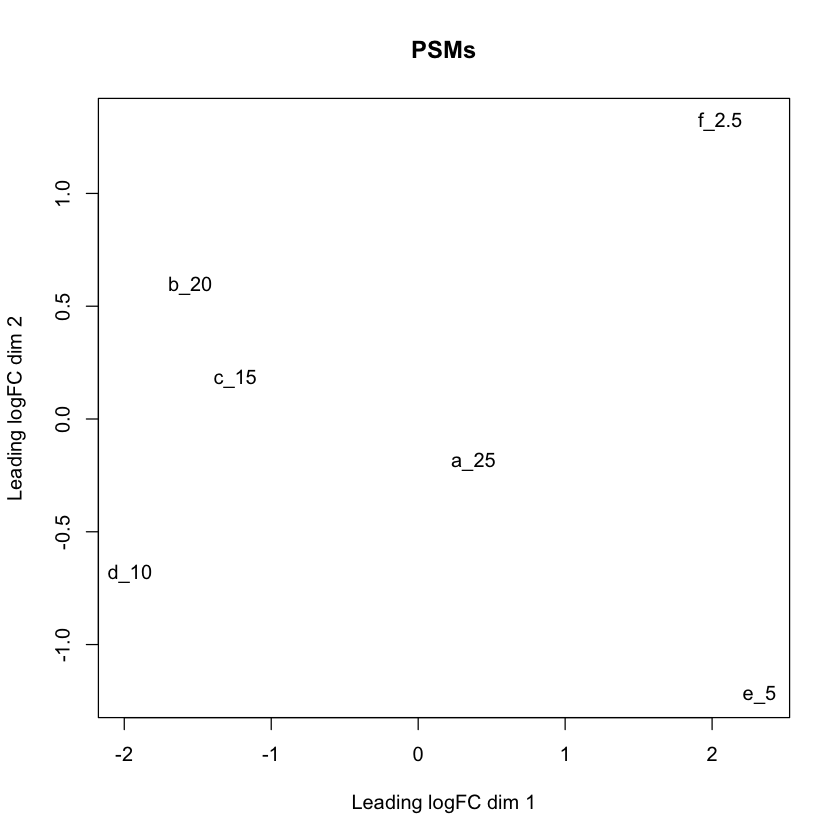

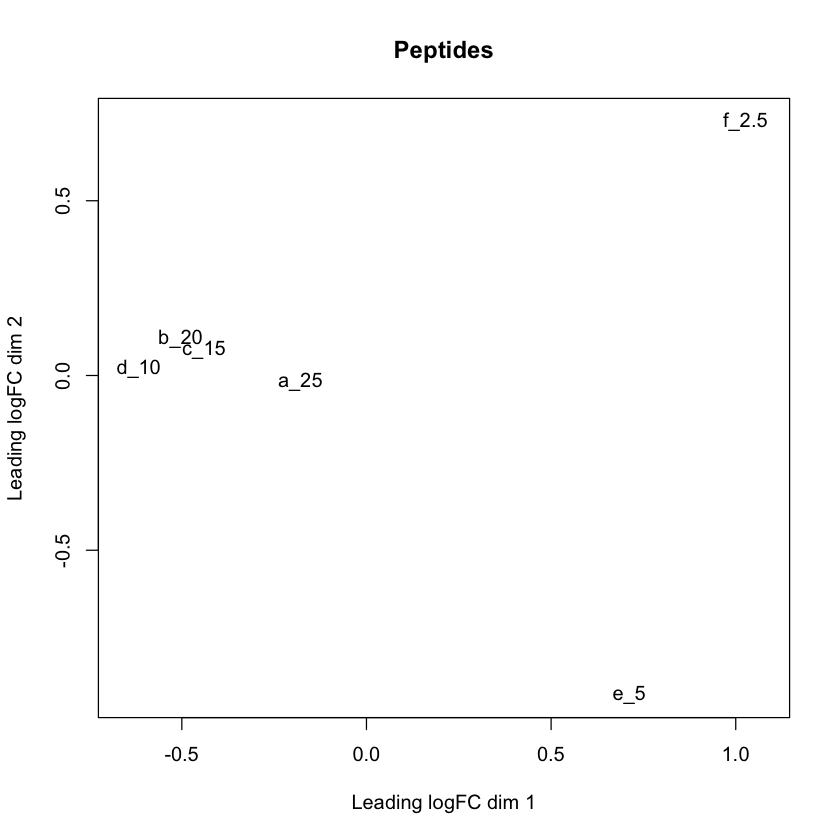

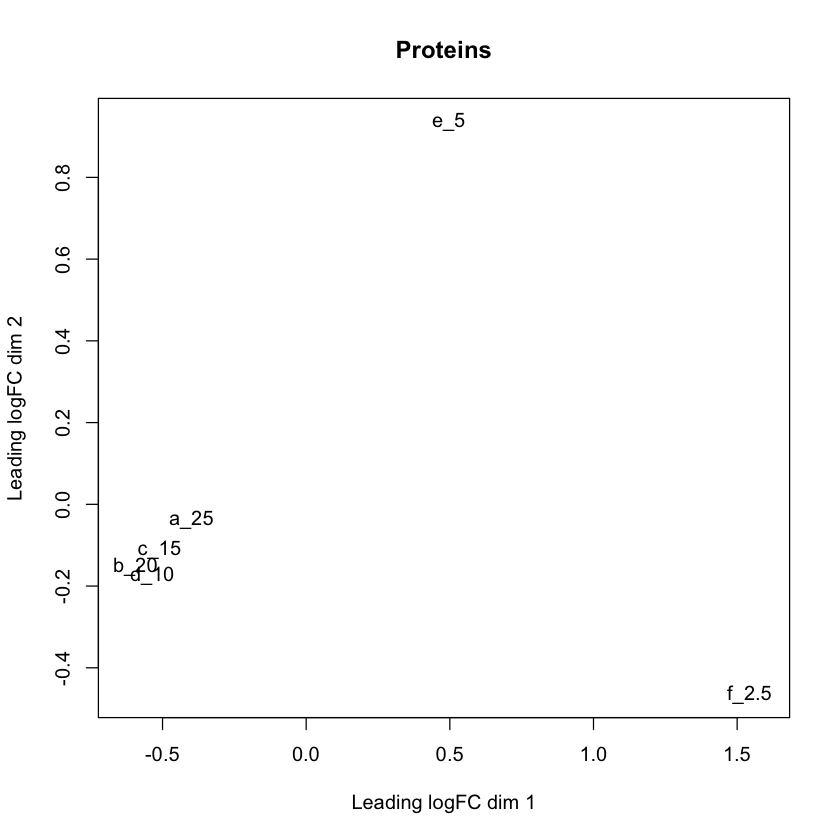

In [26]:
# make multi-dimensional scaling plots to see if series are similar
plotMDS(calcNormFactors(y_psms), main = "PSMs")
plotMDS(calcNormFactors(y_peptides), main = "Peptides")
plotMDS(calcNormFactors(y_proteins), main = "Proteins")

### The two lowest dilutions should be dropped
The 5 and 2.5 dilutions are a little too weak in intensities to be as similar to the other dilutions as we might like. If we drop those two dilutions, we still have 4 for the CV calculation. We can define a function to do the edgeR steps (TMM normalization and cpm conversion) and then compute the CV distribution.

In [27]:
# define a function for normalizing data and computing CVs
get_cv <- function(DGE) {
    # normalizes edgeR data, makes cpm scale, computes CV distribution
        # DGE - edgeR DGEList object
        # returns a CV distribution vector
    
    # get a cmp scale table of normalized data
    CPM <- as.data.frame(cpm(calcNormFactors(DGE)))

    # compute CVs for first 4 channels (drop the 5 and 2.5 dilutions)
    cv <- 100 * apply(CPM[1:4], 1, sd) / rowMeans(CPM[1:4])
}

# compute the CVs and look at the distribution summary numbers
psm_cvs <- get_cv(y_psms)
peptide_cvs <- get_cv(y_peptides)
protein_cvs <- get_cv(y_proteins)

print("PSM CVs:")
summary(psm_cvs)

print("Peptide CVs:")
summary(get_cv(y_peptides))

print("Protein CVs:")
summary(get_cv(y_proteins))

[1] "PSM CVs:"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.1648   5.2603   8.4417  11.6175  13.4356 105.0082 

[1] "Peptide CVs:"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.06104  4.56621  7.15830  8.80831 11.01174 92.24860 

[1] "Protein CVs:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1003  2.4117  4.1561  6.5506  7.5986 98.5654 

### Look at the distributions of CV values at each aggregation level
There are some differences between the median and mean CVs (above) because the distributions are not symmetric. They tail on the larger CV side. 

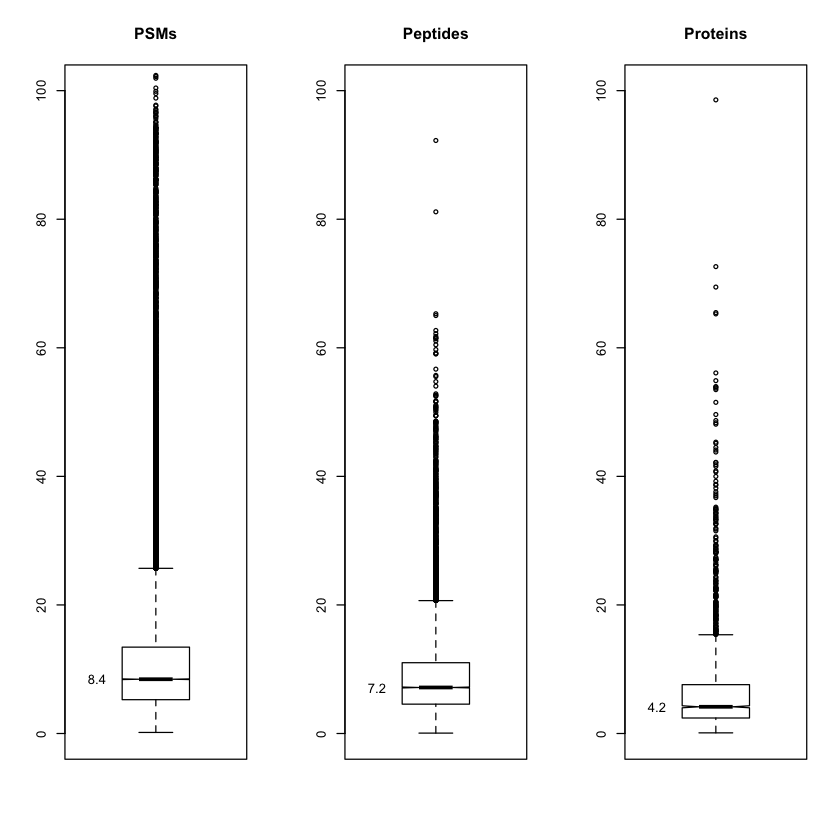

In [28]:
BP <- function(cv, ymax, title) {
    # returns a labeled boxplot
        # cv - vector of CV values
        # ymax - upper limit for plot
        # title - main plot title
    
    # make the box plot and label the median
    bp  <- boxplot(cv, ylim = c(0, ymax), notch = TRUE, main = title)
    label <- text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
    list(bp, label)
}

# compare some box plots of the CV distributions
par(mfrow = c(1, 3))
plot.label <- BP(get_cv(y_psms), 100, "PSMs")
plot.label <- BP(get_cv(y_peptides), 100, "Peptides")
plot.label <- BP(get_cv(y_proteins), 100, "Proteins")
par(mfrow = c(1, 1))

---
## Conclusions
Protein intensities have smaller variances (tighter scatter plots and smaller median CVs) and increased dynamic range compared to PSM or peptide level measures. There is also a dramatic reduction in the number of data points. There are 22-fold fewer proteins than PSMs and almost 8-fold fewer proteins than peptides. Summing filtered PSM reporter ions into protein totals is an effective and simple way to aggregate TMT data.

The differences in the dilutions provided a nice context to see what typical data normalizations in edgeR do to data. While we diluted the same sample on purpose, it was still the same sample. Many normalization methods can correct for differences in sample loading, which is one extreme way to think about the dilutions. 

We were able to use "normalization" to make the samples similar so that we could compute quantities like CV values. Data sets with large numbers of technical replicates are hard to find. That is why we spent some effort to get a little more mileage out of this data.

R and notebooks (or R Markdown in [RSudio](https://www.rstudio.com/) are powerful frameworks for being able to manipulate and visualize data. We discovered that the FT instruments from Thermo can have some data idiosyncrasies like the "notch". We would never have seen that if we had not taken the time to look.

In [29]:
# log the R session (we should always end notebooks with this)
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.2

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] edgeR_3.24.2    limma_3.38.3    forcats_0.3.0   stringr_1.3.1  
 [5] dplyr_0.7.8     purrr_0.2.5     readr_1.3.1     tidyr_0.8.2    
 [9] tibble_1.4.2    ggplot2_3.1.0   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     locfit_1.5-9.1   tidyselect_0.2.5 repr_0.18       
 [5] haven_2.0.0      lattice_0.20-38  colorspace_1.3-2 generics_0.0.2  
 [9] htmltools_0.3.6  base64enc_0.1-3  rlang_0.3.0.1    pillar_1.3.1    
[13] glue_1.3.0       withr_2.1.2      modelr_0.1.